# S Parameter Extraction of an MMI Coupler

In this tutorial, we'll use the `EigenModeSource` and mode decomposition routines to extract the scattering parameters (S parameters) of a mutlti-mode interferometric (MMI) coupler.

First we'll load our required modules and the dispersive materials we want to use for our core and cladding (silicon and silicon dioxide respectively) from the meep materials library.

In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from meep.materials import Si, SiO2

Using MPI version 3.1, 1 processes


Next we'll define our MMI coupler geometry parameters. We'll connect our coupler with three waveguides of width (`wg`) of 1 $\mu$m, length (`wg_len`) of 4 $\mu$m, and separated by a distance (`wg_sp`) of 3 $\mu$m. The coupler region has a length, `Lw` of 10 $\mu$m and and width, `Ww` of 6 $\mu$m.

In [2]:
wg = 1.0          # width of waveguides in microns
wg_sp = 3.0       # separation between waveguides
wg_len = 4        # length of each waveguide
Lw = 10.0         # length of MMI
Ww = 6.0          # width of MMI coupler
y_padding = 2.0   # padding between coupler and y borders

resolution = 10

Next we'll build the geometry from the above parameters.

In [3]:
mmi = mp.Block(center=mp.Vector3(),size=mp.Vector3(Lw,Ww,mp.inf),material = Si)
wg_left = mp.Block(center=mp.Vector3(-Lw/2-wg_len/2),size=mp.Vector3(wg_len+1,wg,mp.inf),material = Si)
wg_right_1 = mp.Block(center=mp.Vector3(Lw/2+wg_len/2,wg_sp/2+wg/2),size=mp.Vector3(wg_len+1,wg,mp.inf),material = Si)
wg_right_2 = mp.Block(center=mp.Vector3(Lw/2+wg_len/2,-wg_sp/2-wg/2),size=mp.Vector3(wg_len+1,wg,mp.inf),material = Si)
    
geometry=[mmi,wg_left,wg_right_1,wg_right_2]


We'll define our boundary layers

In [4]:
dpml = 1.0
boundary_layers = [mp.PML(dpml)]

and our simulation cell size

In [5]:
sx = 2 * wg_len + Lw
sy = Ww + 2*y_padding
cell_size = mp.Vector3(sx,sy)

We'll then define a contiuous wave (CW) source at an operating wavelength of 6 $\mu$m.

In [6]:
lcen = 6       # mode wavelength
fcen = 1/lcen     # mode frequency

src_pt = mp.Vector3(-0.5*sx+dpml+0.5)
sources = [mp.EigenModeSource(src=mp.ContinuousSource(fcen),
                              center=src_pt,
                              size=mp.Vector3(y=sy-2*dpml),
                              eig_match_freq=True,
                              eig_parity=mp.ODD_Z)]

Finally, we'll formulate our simulation object, run the simulation, and visualize the steady state field distribution:

In [7]:
sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    sources=sources,
                    Courant=0.2,
                    default_material=SiO2,
                    geometry=geometry)

In [8]:
sim.run(until=1000)

-----------
Initializing structure...
     block, center = (0,0,0)
          size (10,6,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-7,0,0)
          size (5,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (7,2,0)
          size (5,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (7,-2,0)
          size (5,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Meep progress: 155.08/1000.0 = 15.5% done in 4.0s, 21.8s to go
Meep progress: 314.86/1000.0 = 31.5% done in 8.0s, 17.4s to go
Meep progress: 489.92/1000.0 = 49.0% done in 12.0s, 12.5s to go
Meep progress: 665.44/1000.0 = 66.5% done in 16.0s, 8.0s to go
Meep progress: 834.84/1000.0 = 83.5% done in 20.0s, 4.0s to go
Meep progress: 997.0400000000001/1000.0 = 99.7% done in 24.0s, 0.1s to go
run 0 finished at t = 1000.0 (50000 timesteps)


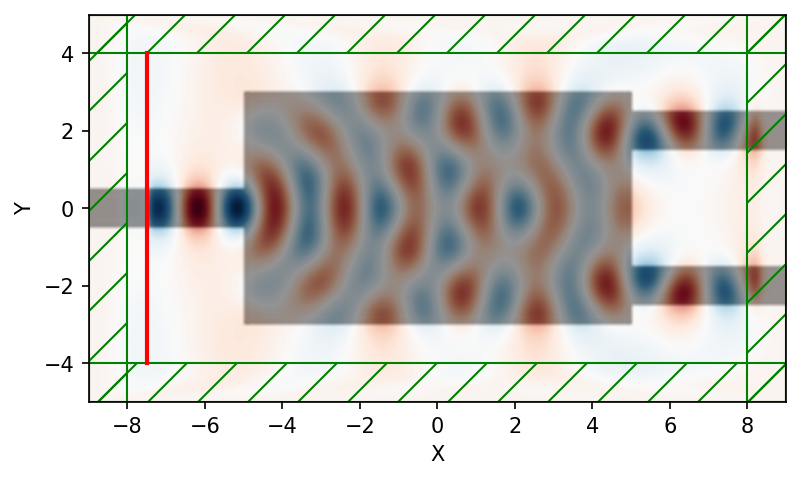

In [9]:
f = plt.figure(dpi=150)
sim.plot2D(ax=f.gca(),fields=mp.Ez)
plt.show()

As expected, the fields are symmetrically distributed across the x axis. Let's slightly raise the `Y` position of the input waveguide so the structure is no longer symmetric.

Alternatively, we could have solved for the steady state field distribution in the _frequency domain_ using the frequency domain method (`solve_cw`). Timestepping by 1000 timesteps is significantly faster for this geometry, however.

We can also inject the simulation with a broadband, gaussian source so that we can extract the corresponding S parameters.

In [10]:
mmi = mp.Block(center=mp.Vector3(),size=mp.Vector3(Lw,Ww,mp.inf),material = Si)
wg_left = mp.Block(center=mp.Vector3(-Lw/2-wg_len/2,1),size=mp.Vector3(wg_len+1,wg,mp.inf),material = Si)
wg_right_1 = mp.Block(center=mp.Vector3(Lw/2+wg_len/2,wg_sp/2+wg/2),size=mp.Vector3(wg_len+1,wg,mp.inf),material = Si)
wg_right_2 = mp.Block(center=mp.Vector3(Lw/2+wg_len/2,-wg_sp/2-wg/2),size=mp.Vector3(wg_len+1,wg,mp.inf),material = Si)
    
geometry=[mmi,wg_left,wg_right_1,wg_right_2]

lcen = 6.0       # mode wavelength
fcen = 1/lcen     # mode frequency
df = 0.2*fcen

src_pt = mp.Vector3(-0.5*sx+dpml+0.5)
sources = [mp.EigenModeSource(src=mp.ContinuousSource(fcen),
                              center=src_pt,
                              size=mp.Vector3(y=sy-2*dpml),
                              eig_match_freq=True,
                              eig_parity=mp.ODD_Z+mp.EVEN_Y)]

We'll now regenerate our simulation object and place monitors of hight 3 $\mu$m on each waveguide.

In [11]:
sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    sources=sources,
                    default_material=SiO2,
                    Courant=0.2,
                    geometry=geometry)
nf = 100
ddf = df/nf

monitor_height = 3

mon_pt_1 = mp.Vector3(-0.5*sx+dpml+2,1)
flux_1 = sim.add_flux(fcen,ddf,int(nf/2),mp.FluxRegion(center=mon_pt_1,size=mp.Vector3(y=monitor_height)))
mon_pt_2 = mp.Vector3(Lw/2+wg_len/2,wg_sp/2+wg/2)
flux_2 = sim.add_flux(fcen,ddf,int(nf/2),mp.FluxRegion(center=mon_pt_2,size=mp.Vector3(y=monitor_height)))
mon_pt_3 = mp.Vector3(Lw/2+wg_len/2,-wg_sp/2-wg/2)
flux_3 = sim.add_flux(fcen,ddf,int(nf/2),mp.FluxRegion(center=mon_pt_3,size=mp.Vector3(y=monitor_height)))

We'll visualize the resulting structure to make sure our input waveguide and mode monitors were placed properly.

-----------
Initializing structure...
     block, center = (0,0,0)
          size (10,6,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-7,1,0)
          size (5,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (7,2,0)
          size (5,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (7,-2,0)
          size (5,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)


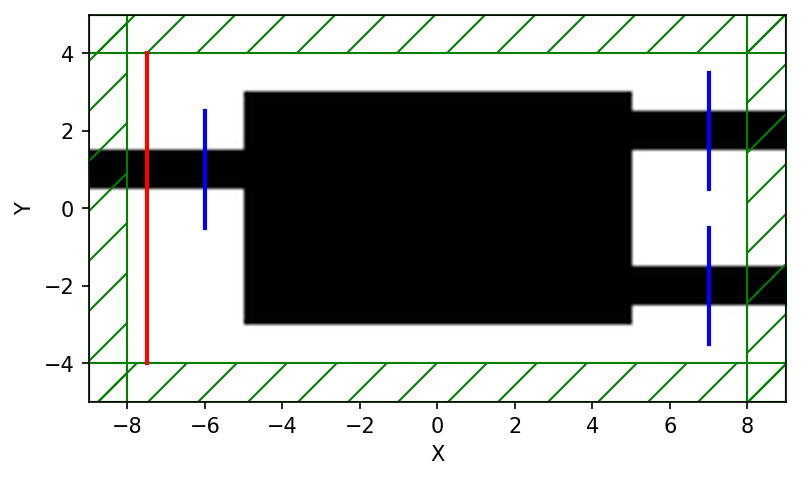

In [12]:
f = plt.figure(dpi=150)
sim.plot2D(ax=f.gca())
plt.show()

Finally we'll run our simulation and record the fields at the monitors for some post-procesing:

In [13]:
sim.run(until=1000)

Meep progress: 151.14000000000001/1000.0 = 15.1% done in 4.0s, 22.5s to go
Meep progress: 293.74/1000.0 = 29.4% done in 8.0s, 19.2s to go
Meep progress: 439.54/1000.0 = 44.0% done in 12.0s, 15.3s to go
Meep progress: 584.86/1000.0 = 58.5% done in 16.0s, 11.4s to go
Meep progress: 734.5600000000001/1000.0 = 73.5% done in 20.0s, 7.2s to go
Meep progress: 880.36/1000.0 = 88.0% done in 24.0s, 3.3s to go
run 0 finished at t = 1000.0 (50000 timesteps)


Now that the simulation has run and the relevant fields are stored in our mode monitors, we can calculate the S parameters we care about. To do so, we first need to pull the forward and backward mode coupling coefficients at each frequency point for each monitor using the `get_eigenmode_coefficients` routine.

In this example, we only care about the fundamental TE mode. We'll pass a list of just the first band (`[1]`) and specify the corresponding parity/polarization of the mode (`mp.ODD_Z+mp.EVEN_Y`). Each monitor will return a `NamedTuple` object that contains information about the mode `k` vector, the group velocity, and the forward and backward coefficients. 

Since we want the forward and backward coeffiecients, we'll use the `alpha` attribute to pull a multidimensional array that is $M \times N \times 2$, where $M$ is the number of modes we passed (just one) and $N$ is the number of frequency points. We can then pull the forward $\alpha$ and backward $\beta$ coupling coeffiecients from each array.  

In [14]:
freqs = np.array(mp.get_eigenmode_freqs(flux_1))
wavelength = 1/freqs

res_1 = sim.get_eigenmode_coefficients(flux_1,[1],eig_parity=mp.ODD_Z+mp.EVEN_Y)
res_2 = sim.get_eigenmode_coefficients(flux_2,[1],eig_parity=mp.ODD_Z+mp.EVEN_Y)
res_3 = sim.get_eigenmode_coefficients(flux_3,[1],eig_parity=mp.ODD_Z+mp.EVEN_Y)


a1 = res_1.alpha[0,:,0]
b1 = res_1.alpha[0,:,1]

a2 = res_2.alpha[0,:,0]
b2 = res_2.alpha[0,:,1]

a3 = res_3.alpha[0,:,0]
b3 = res_3.alpha[0,:,1]

Now, using the above coupling coefficients, the S parameters are just ratios of the input port and output port. For example, if want to calculate the $S_{13}$ parameter (i.e. light injected into port 1 and measured at port 3) we analyze the _forward_ coefficient of port 3 (`a3`) relative to the forward coefficient of port 1 (`a1`). In other words, `S13=a3/a1`. We can similarly calculate $S_{12}$ with `S12=a2/a1`.

If we want to calculate the $S_{11}$ parameter (i.e. the reflected light measured at port 1 after injecting at port 1) we analyze the _backward_ coefficient of port 1 (`b1`) relative to the forward coefficient of port 1 (`a1`).

In [15]:
S11 = b1 / a1
S12 = a2 / a1
S13 = a3 / a1

Finally, we'll visualize both the magnitude and phase of each of the S parameters.

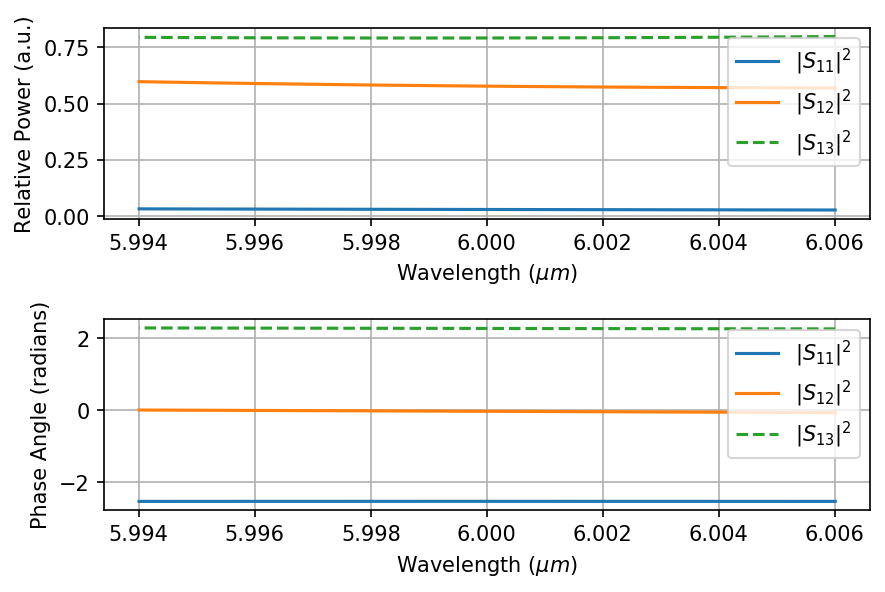

In [16]:
plt.figure(dpi=150)

plt.subplot(2,1,1)
plt.plot(wavelength,np.abs(S11)**2,label='$|S_{11}|^2$')
plt.plot(wavelength,np.abs(S12)**2,label='$|S_{12}|^2$')
plt.plot(wavelength,np.abs(S13)**2,'--',label='$|S_{13}|^2$')
plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('Relative Power (a.u.)')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(wavelength,np.angle(S11),label='$|S_{11}|^2$')
plt.plot(wavelength,np.angle(S12),label='$|S_{12}|^2$')
plt.plot(wavelength,np.angle(S13),'--',label='$|S_{13}|^2$')
plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('Phase Angle (radians)')
plt.legend()
plt.grid(True)



plt.tight_layout()
plt.show()

As expected, the $S_{12}$ and $S_{13}$ parameters are _different_ since the structure is no longer symmetric.

Ideally, we would excite all of the other waveguides and extract those S parameters so that we can formulate the entire scattering matrix for each wavelength point. This matrix can then be used to simulate larger circuits without running an entire FDTD simulation over the circuit.